In [1]:
# Importing dependencies

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.diagnostic import het_white

from math import sqrt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading feature set into memory and instantiating dataframe

df = pd.read_csv('../../data/processed/cleaned_feature_set.csv', index_col = 0)
df

,Solar Energy (kWh),Inverter 1 Energy (kWh),Inverter 2 Energy (kWh),Daylength in decimal hours,Billing Period Duration (Days),Billable kWh,Power Bill Total,Tesla Bill Total,Total Cost
Billing Period End,,,,,,,,,
12/17/2021,590.2,282.2,307.8,251.94,30,1123,195.13,185,380.13
1/19/2022,366.8,77.1,289.7,266.70,32,2046,347.39,185,532.39
2/16/2022,738.0,355.5,382.6,244.05,27,829,146.63,185,331.63
3/21/2022,1280.5,608.4,672.1,320.33,32,160,36.27,185,221.27
4/19/2022,1323.8,641.0,682.7,312.83,28,473,87.90,185,272.90
5/18/2022,1511.0,736.2,775.2,339.47,28,352,61.97,185,246.97
6/17/2022,1546.6,752.0,794.8,369.80,29,882,133.15,185,318.15
7/19/2022,1594.7,775.0,819.6,395.68,31,1410,206.94,185,391.94
8/16/2022,1123.7,547.8,576.0,330.32,27,1448,212.25,185,397.25


In [3]:
# Creating NaNs from 0s in `Inverter 2 Energy (kWh)` column
# and forward-fill them with the mean for measuring error later

df.replace(0, np.nan, inplace=True)
df = df.fillna(df['Inverter 2 Energy (kWh)'].mean())

<AxesSubplot:>

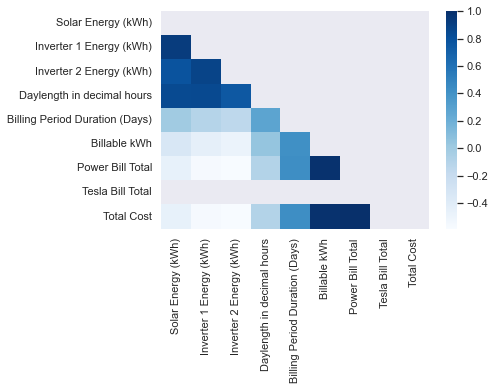

In [4]:
# Correlation matrix

sns.set(rc = {'figure.figsize':(15,8)})
corr = df.corr()
mask = np.triu(corr)
sns.heatmap(corr, cmap="Blues", mask=mask)

In [5]:
# Test set is two rows, Oct. and Nov. of 2022

X_test = df[['Daylength in decimal hours', 'Billing Period Duration (Days)']][-2:]
y_test = df['Inverter 2 Energy (kWh)'][-2:]

In [6]:
# Training set is first ten rows (12-2021 thru 9-2022)

X_train = df[['Daylength in decimal hours', 'Billing Period Duration (Days)']][:-2]
y_train = df['Inverter 2 Energy (kWh)'][:-2]

In [7]:
# Fitting a regressor to the training data

model = LinearRegression(fit_intercept=True).fit(X_train, y_train)

# Using feature weights as a proxy for feature importance

weights = model.coef_

feature = []
weight = []

for i, v in enumerate(weights):
    feature.append(i)
    weight.append(f'{v.round(4)}')
    
# Packaging it all up as a dataframe
    
df = pd.DataFrame({'feature': feature,
                   'weight': weight}).sort_values(by='weight', ascending=False)

df.feature = X_train.columns

df.weight = pd.to_numeric(df.weight)

df.sort_values(by='weight', ascending=False).reset_index(drop=True)

,feature,weight
0,Daylength in decimal hours,3.4591
1,Billing Period Duration (Days),-33.4487


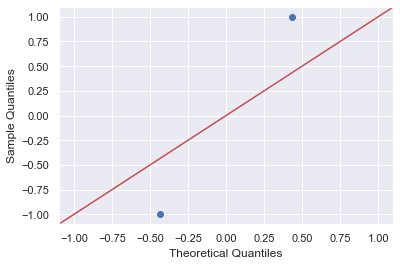

In [8]:
# Residuals seem reasonably close to the line

y_pred = model.predict(X_test)

residuals = y_test - y_pred

fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)

In [9]:
# Predicted energy generated by inverter 2 for the months
# it was malfunctioning passes the sniff test

y_pred

array([509.19796447, 407.39892034])

In [10]:
# Calculating RMSE

rmse = sqrt(mean_squared_error(y_test, y_pred))

In [11]:
# This suggests that the model is predicting within
# 130 kWh for the month based on the mean that was calculated earlier

rmse

130.59865586404544